## Library and Downloads

In [ ]:
#Uncomment to install vaderSentiment if haven't alredy
#!pip install vaderSentiment pandas matplotlib tqdm

### Libraries
import pandas as pd
import numpy as np
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from google.colab import files
import io
from wordcloud import WordCloud
import torch
import torch.nn as nn
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, DistilBertTokenizerFast, DistilBertModel,DistilBertForSequenceClassification
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, DataLoader


In [ ]:
### NLTK Downloads
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Reading, Cleaning, and Preprocessing

In [ ]:
### Loading Data
fake_df = pd.read_csv('fake.csv')
true_df = pd.read_csv('true.csv')

In [ ]:
### Data Cleaning
# Adding 'label' column to identify true and fake news
true_df['label'] = 1
fake_df['label'] = 0

# Concatenate the true and fake news datasets
df = pd.concat([true_df, fake_df], ignore_index=True)

In [ ]:
### Data Check
print("First few rows of the dataset:")
print(df.head())

print("\nMissing values in the dataset:")
print(df.isnull().sum())

First few rows of the dataset:
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  label  
0  December 31, 2017       1  
1  December 29, 2017       1  
2  December 31, 2017       1  
3  December 30, 2017       1  
4  December 29, 2017       1  

Missing values in the da

In [ ]:
### Drop Duplicates
# Count the number of duplicates before dropping
num_duplicates_before = df.duplicated().sum()

# Drop duplicates
df.drop_duplicates(inplace=True)

# Count the number of duplicates after dropping
num_duplicates_after = num_duplicates_before - len(df)

print("Number of duplicates dropped:", num_duplicates_after)


Number of duplicates dropped: -44480


In [ ]:
### Defining Preprocess Function
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text.lower())

    # Removing stopwords and non-alphabetic tokens
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(preprocess_text)

In [ ]:
### Data Splitting
train_val_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.2, random_state=42)

print("\nTrain set shape:", train_data.shape)
print("Validation set shape:", val_data.shape)
print("Test set shape:", test_data.shape)


Train set shape: (28600, 6)
Validation set shape: (7151, 6)
Test set shape: (8938, 6)


## EDA Visualization

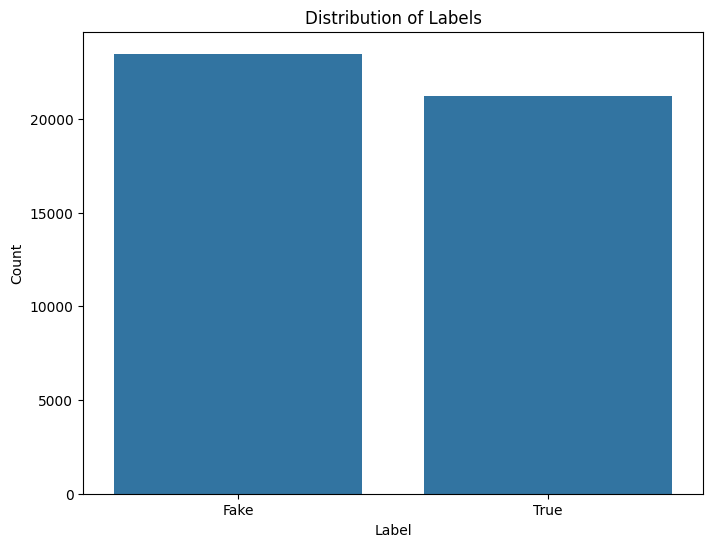

In [ ]:
### Label Distribution Boxplot
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Fake', 'True'])
plt.show()

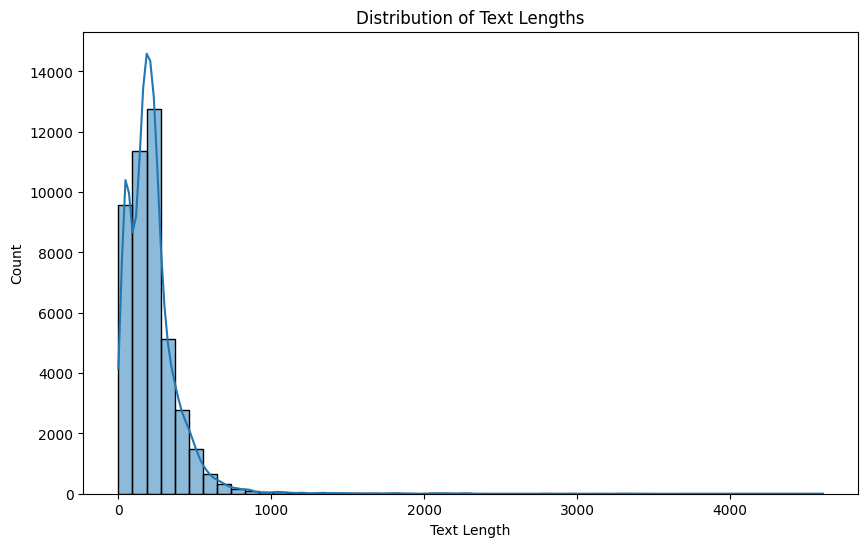

In [ ]:
### Text Lenght Distribution
df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

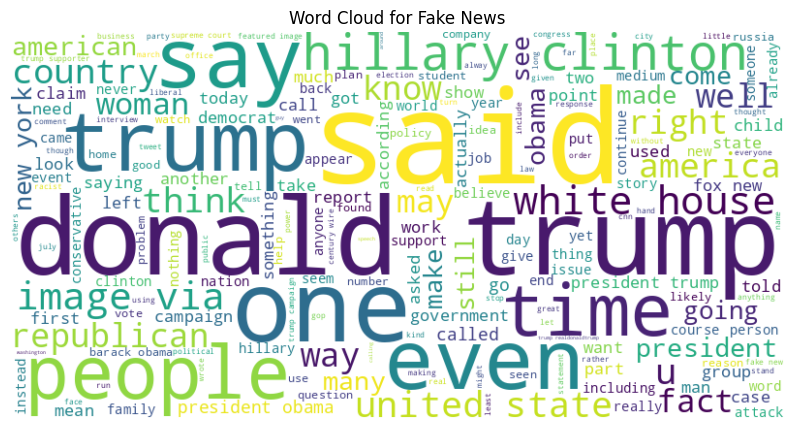

In [ ]:
### Word Cloud
fake_text = ' '.join(df[df['label'] == 0]['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(fake_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Fake News')
plt.axis('off')
plt.show()


Sentiment Analysis: 100%|██████████| 44689/44689 [10:09<00:00, 73.29it/s]


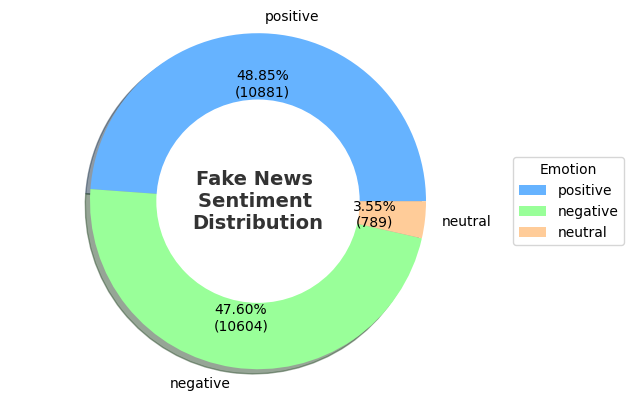

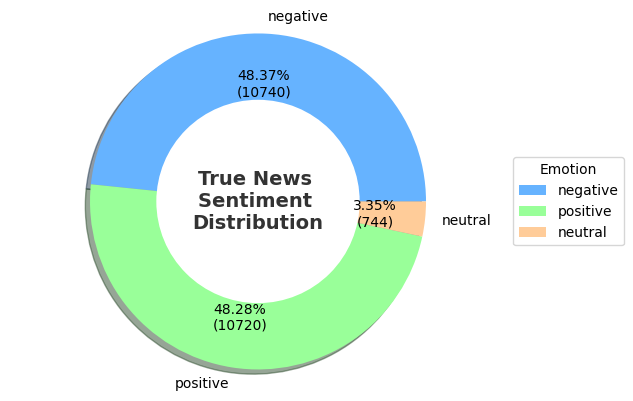

In [ ]:
# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
res = {}

# Iterate through the DataFrame rows
for i, row in tqdm(df.iterrows(), total=len(df), desc="Sentiment Analysis"):
    text = row['text']
    my_id = row['title']
    res[my_id] = sia.polarity_scores(text)

# Convert the results into a DataFrame
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'title'})
vaders = vaders.merge(df, how='left', on='title')

# Define the polarity score function
def polarity_score(compound):
    if compound > 0.05:
        return "positive"
    elif compound < -0.05:
        return "negative"
    else:
        return "neutral"

# Apply the polarity score function
vaders['sentiment'] = vaders['compound'].apply(lambda val: polarity_score(val))
# Ensure your DataFrame has a 'NewsType' column with 'fake' and 'true' labels
df['NewsType'] = np.random.choice(['fake', 'true'], size=len(df))
vaders['NewsType'] = df['NewsType']  # Uncomment and adjust if you have this information in the original DataFrame

# Filter the DataFrame by news type
fake_news = vaders[vaders['NewsType'] == 'fake']
true_news = vaders[vaders['NewsType'] == 'true']

# Sentiment distribution for fake news
fake_emotion_counts = fake_news['sentiment'].value_counts()

# Sentiment distribution for true news
true_emotion_counts = true_news['sentiment'].value_counts()
# Visualization function
def plot_sentiment_distribution(emotion_counts, title):
    fig, ax = plt.subplots()
    colors = ['#66b3ff', '#99ff99', '#ffcc99']
    wedges, texts, autotexts = ax.pie(
        x=emotion_counts,
        labels=emotion_counts.index,
        autopct=lambda p: f'{p:.2f}%\n({int(p*sum(emotion_counts)/100)})',
        wedgeprops=dict(width=0.7),
        textprops=dict(size=10, color="black"),
        pctdistance=0.7,
        colors=colors,
        shadow=True
    )
    center_circle = plt.Circle((0, 0), 0.6, color='white', fc='white', linewidth=1.25)
    fig.gca().add_artist(center_circle)
    ax.text(0, 0, title, ha='center', va='center', fontsize=14, fontweight='bold', color='#333333')
    ax.legend(emotion_counts.index, title="Emotion", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    ax.axis('equal')
    plt.show()

# Plot sentiment distributions
plot_sentiment_distribution(fake_emotion_counts, 'Fake News \nSentiment \nDistribution')
plot_sentiment_distribution(true_emotion_counts, 'True News \nSentiment \nDistribution')



## Machine Learning

In [ ]:
### Set up data for ML
# Combine the datasets
combined_df = pd.concat([true_df, fake_df], ignore_index=True)

# Shuffle the data
combined_df = combined_df.sample(frac=1).reset_index(drop=True)

# Combine the title and text columns for better features
combined_df['text'] = combined_df['title'] + " " + combined_df['text']

# Drop unnecessary columns if present
combined_df = combined_df[['text', 'label']]

stop_words = stopwords.words('english')

# Initialize TfidfVectorizer with stopwords
tfidf = TfidfVectorizer(stop_words=stop_words, max_df=0.7)

# Transform the text data into TF-IDF features
X = tfidf.fit_transform(combined_df['text'])

# Encode the labels
le = LabelEncoder()
y = le.fit_transform(combined_df['label'])

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
### Machine Learning Models
# Initialize models
log_reg = LogisticRegression(max_iter=1000)
rand_forest = RandomForestClassifier(n_estimators=100)


# Train the models
log_reg.fit(X_train, y_train)
rand_forest.fit(X_train, y_train)


# Make predictions
log_reg_pred = log_reg.predict(X_test)
rand_forest_pred = rand_forest.predict(X_test)


In [ ]:
#Moved to new block, kept hanging up on my runs - James
svc = SVC(probability=True)
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)

In [ ]:
# Evaluate the models
print("Logistic Regression Accuracy:", accuracy_score(y_test, log_reg_pred))
print("Random Forest Accuracy:", accuracy_score(y_test, rand_forest_pred))
print("SVM Accuracy:", accuracy_score(y_test, svc_pred))

print("\nLogistic Regression Classification Report:\n", classification_report(y_test, log_reg_pred))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, rand_forest_pred))
print("\nSVM Classification Report:\n", classification_report(y_test, svc_pred))

In [ ]:
# Confusion Matrices
log_reg_cm = confusion_matrix(y_test, log_reg_pred)
rand_forest_cm = confusion_matrix(y_test, rand_forest_pred)
svc_cm = confusion_matrix(y_test, svc_pred)

# Plot Confusion Matrices
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
sns.heatmap(log_reg_cm, annot=True, fmt='d', ax=ax[0], cmap='Blues')
ax[0].set_title('Logistic Regression Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

sns.heatmap(rand_forest_cm, annot=True, fmt='d', ax=ax[1], cmap='Blues')
ax[1].set_title('Random Forest Confusion Matrix')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')

sns.heatmap(svc_cm, annot=True, fmt='d', ax=ax[2], cmap='Blues')
ax[2].set_title('SVM Confusion Matrix')
ax[2].set_xlabel('Predicted')
ax[2].set_ylabel('Actual')

plt.show()

In [ ]:
# ROC Curves
log_reg_prob = log_reg.predict_proba(X_test)[:, 1]
rand_forest_prob = rand_forest.predict_proba(X_test)[:, 1]
svc_prob = svc.predict_proba(X_test)[:, 1]

log_reg_fpr, log_reg_tpr, _ = roc_curve(y_test, log_reg_prob)
rand_forest_fpr, rand_forest_tpr, _ = roc_curve(y_test, rand_forest_prob)
svc_fpr, svc_tpr, _ = roc_curve(y_test, svc_prob)

plt.figure(figsize=(10, 8))
plt.plot(log_reg_fpr, log_reg_tpr, label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_score(y_test, log_reg_prob)))
plt.plot(rand_forest_fpr, rand_forest_tpr, label='Random Forest (AUC = {:.2f})'.format(roc_auc_score(y_test, rand_forest_prob)))
plt.plot(svc_fpr, svc_tpr, label='SVM (AUC = {:.2f})'.format(roc_auc_score(y_test, svc_prob)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Precision-Recall Curves
log_reg_precision, log_reg_recall, _ = precision_recall_curve(y_test, log_reg_prob)
rand_forest_precision, rand_forest_recall, _ = precision_recall_curve(y_test, rand_forest_prob)
svc_precision, svc_recall, _ = precision_recall_curve(y_test, svc_prob)

plt.figure(figsize=(10, 8))
plt.plot(log_reg_recall, log_reg_precision, label='Logistic Regression')
plt.plot(rand_forest_recall, rand_forest_precision, label='Random Forest')
plt.plot(svc_recall, svc_precision, label='SVM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

In [ ]:
new_files = [
    './Downloads/Entertainment_News/Entertainment_News.csv',
    './Downloads/Sports_News/Sports_News.csv',
    './Downloads/Business_News/Business_News.csv',
    './Downloads/Science_&_Technology_News/Science_&_Technology_News.csv',
    './Downloads/Health_News/Health_News.csv'
]

In [ ]:
# Process each new file and make predictions
results = []

for file_path in new_files:
    # Load and preprocess the new data
    new_df = pd.read_csv(file_path)

    # Check if 'title' and 'text' columns exist
    if 'title' in new_df.columns and 'full_description' in new_df.columns:
        new_df['full_description'] = new_df['title'].fillna('') + " " + new_df['full_description'].fillna('')
    else:
        continue  # Skip files that do not have the necessary columns

    # Add a placeholder label for comparison
    new_df['label'] = 'unknown'

    new_X = tfidf.transform(new_df['full_description'])  # Transform the new text data using the same TF-IDF vectorizer

    # Make predictions on the new data
    log_reg_new_pred = log_reg.predict(new_X)
    rand_forest_new_pred = rand_forest.predict(new_X)
    svc_new_pred = svc.predict(new_X)

    # Add predictions to the new DataFrame
    new_df['log_reg_pred'] = le.inverse_transform(log_reg_new_pred)
    new_df['rand_forest_pred'] = le.inverse_transform(rand_forest_new_pred)
    new_df['svc_pred'] = le.inverse_transform(svc_new_pred)

    results.append(new_df)

In [ ]:
# Combine all results into a single DataFrame for comparison
all_results = pd.concat(results, ignore_index=True)

In [ ]:
# Plot comparisons of true and false news among these CSV files
plt.figure(figsize=(12, 6))
sns.countplot(x='log_reg_pred', hue='label', data=all_results)
plt.title('Logistic Regression Predictions')
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.legend(title='Actual Label')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(x='rand_forest_pred', hue='label', data=all_results)
plt.title('Random Forest Predictions')
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.legend(title='Actual Label')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(x='svc_pred', hue='label', data=all_results)
plt.title('SVM Predictions')
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.legend(title='Actual Label')
plt.show()

In [ ]:
new_files = {
    'Entertainment News': './Downloads/Entertainment_News/Entertainment_News.csv',
    'Sports News': './Downloads/Sports_News/Sports_News.csv',
    'Business News': './Downloads/Business_News/Business_News.csv',
    'Science & Technology News': './Downloads/Science_&_Technology_News/Science_&_Technology_News.csv',
    'Health News': './Downloads/Health_News/Health_News.csv'
}

In [ ]:
# Process each new file and make predictions
results = []

for label, file_path in new_files.items():
    # Load and preprocess the new data
    new_df = pd.read_csv(file_path)

    # Check if 'title' and 'text' columns exist
    if 'title' in new_df.columns and 'full_description' in new_df.columns:
        new_df['full_description'] = new_df['title'].fillna('') + " " + new_df['full_description'].fillna('')
    else:
        continue  # Skip files that do not have the necessary columns

    # Add a placeholder label for comparison
    new_df['category'] = label

    new_X = tfidf.transform(new_df['full_description'])  # Transform the new text data using the same TF-IDF vectorizer

    # Make predictions on the new data
    log_reg_new_pred = log_reg.predict(new_X)
    rand_forest_new_pred = rand_forest.predict(new_X)
    svc_new_pred = svc.predict(new_X)

    # Add predictions to the new DataFrame
    new_df['log_reg_pred'] = le.inverse_transform(log_reg_new_pred)
    new_df['rand_forest_pred'] = le.inverse_transform(rand_forest_new_pred)
    new_df['svc_pred'] = le.inverse_transform(svc_new_pred)

    results.append(new_df)

In [ ]:
# Combine all results into a single DataFrame for comparison
all_results = pd.concat(results, ignore_index=True)

In [ ]:
# Plot comparisons of true and false news among these CSV files for each model
for model in ['log_reg_pred', 'rand_forest_pred', 'svc_pred']:
    plt.figure(figsize=(12, 6))
    sns.countplot(x=model, hue='category', data=all_results)
    plt.title(f'{model} Predictions')
    plt.xlabel('Prediction')
    plt.ylabel('Count')
    plt.legend(title='Category')
    plt.show()

## Models

In [ ]:
### Tokenize and create train, val, test labels for the data
df['clean_text'] = df['text'].apply(preprocess_text)


train_val_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.2, random_state=42)


vocab_size = 20000
embedding_dim = 100
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"


tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(df['clean_text'])
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_data['clean_text'])
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(val_data['clean_text'])
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_data['clean_text'])
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


train_labels = train_data['label']
val_labels = val_data['label']
test_labels = test_data['label']


#### CNN

In [ ]:

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


model.summary()


history = model.fit(train_padded, train_labels, epochs=5, validation_data=(val_padded, val_labels), verbose=2)


test_loss, test_acc = model.evaluate(test_padded, test_labels, verbose=2)
print('\nTest Accuracy:', test_acc)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          2000000   
                                                                 
 conv1d (Conv1D)             (None, 196, 128)          64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

KeyboardInterrupt: 

#### LSTM

In [ ]:
# LSTM Model
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dense(24, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model Summary
model.summary()

# Train the model
history = model.fit(train_padded, train_labels, epochs=5, validation_data=(val_padded, val_labels), verbose=2)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_padded, test_labels, verbose=2)
print('\nTest Accuracy:', test_acc)



### DistilBERT

Extremely memory intensive and needs a GPU to run

In [ ]:

true_df['label'] = 1
fake_df['label'] = 0
distilbert_df = pd.concat([true_df, fake_df], ignore_index=True)
num_duplicates_before = distilbert_df.duplicated().sum()
distilbert_df.drop_duplicates(inplace = True)
num_duplicates_after = num_duplicates_before - len(distilbert_df)
print('Dropped:', num_duplicates_after)


distilbert_df = distilbert_df[0:30000] #See if it improves memory
print(len(distilbert_df))

#GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device == torch.device('cuda'):
  print('Cuda GPU')
else:
  print('CPU')

#Inspiration: https://www.analyticsvidhya.com/blog/2023/06/step-by-step-bert-implementation-guide/
### Used BERT but I substitued DistilBERT


Dropped: -44480
30000
Cuda GPU


In [ ]:
#Train, Test, Validation
#Had to use Distilbert_df for memory issues

train_text, temp_text, train_labels, temp_labels = train_test_split(distilbert_df['text'], distilbert_df['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=distilbert_df['label'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state = 2018,
                                                                test_size = 0.5,
                                                                stratify = temp_labels)

In [ ]:
#distilbert uses pre-train model from AutoModel from HuggingFace
#Allows for use of BERT architecture and pre-trained weights but computationally cheaper
#DistilBERT Tokenizer converts input text into DistilBERT specific tokens

distilbert = AutoModel.from_pretrained('distilbert-base-uncased')

distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = distilbert_tokenizer.batch_encode_plus( #Batch_encode is a memory efficient method
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = distilbert_tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = distilbert_tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
### Convert data to tensors for efficiency with PyTorch

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())



In [ ]:
#TensorDataset wraps input sequences, attention masks, and labels into single object
#Randomsampler is self-explanatory. Done to ensure diverse data representation in training
#SequetialSampler is for validation to sequentially test the data
#DataLoader allows for iteration over datasets with specific batch sizes for efficency and batching



#Batch Size
batch_size = 32


#Tensor wrapping
train_data = TensorDataset(train_seq, train_mask, train_y)

#Sampler for Training Data
train_sampler = RandomSampler(train_data)

#DataLoader for Training Set
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

#Wrap Validation Tensor
val_data = TensorDataset(val_seq, val_mask, val_y)

#Sampler for Validation Data
val_sampler = RandomSampler(val_data)

#DataLoader for Validation
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)

In [ ]:
# Need to freeze all parameters so parameters of the added layers are trained
# Allows for use of pre-trained BERT model for transfer learning

for param in distilbert.parameters():
  param.requires_grad = False

In [ ]:
#Model Architecture
class distilBERT_Arch(nn.Module):
  def __init__(self,distilbert):
    super(distilBERT_Arch, self).__init__()

    self.distilbert = distilbert

    #Dropout
    self.dropout = nn.Dropout(0.1)
    #self.dropout2 = nn.Dropout(0.25) #Running into overfitting, had to increase dropout size

    #ReLU
    self.relu = nn.ReLU()

    #Dense Layers
    self.fc1 = nn.Linear(768,2) #768 is the output size of BERT base
  #  self.fc2 = nn.Linear(512,2)


  #### Testing to see which works best
    #SoftMax
  #  self.softmax = nn.LogSoftmax(dim=1)

    #Sigmoid
    self.sigmoid = nn.Sigmoid()

  #Forward Pass
  def forward(self, sent_id, mask):
    #Input -> Model
        output = self.distilbert(sent_id, attention_mask=mask)
        cls_hs = output.last_hidden_state[:, 0, :]  # Get the CLS token
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
       # x = self.fc2(x)
       # x = self.dropout2(x)
        x = self.sigmoid(x)
        return x
# By using self.bert = bert, this is calling back to the pre-trained BERT model to use as the foundation of the model

In [ ]:
# Moving model to Cuda for performance

model = distilBERT_Arch(distilbert)
model = model.to(device)

#Trying to figure out if this is necessary. Wants to run on GPU for NVIDA.
#Looking for alternatives


In [ ]:
#AdamW optimizer is used because it includes weight decay regularization
#Weight decay is a regularization term that penalizes large weights

# from transformers import AdamW - deprecated

optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-5)

#computer_class_weights computes the weights with multiple parameters from training data
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels
                                    )
#https://stackoverflow.com/questions/69783897/compute-class-weight-function-issue-in-sklearn-library-when-used-in-keras-cl
print("Class Weights:", class_weights)


Class Weights: [1.70676203 0.70716595]


In [ ]:
#Convert class weights to a tensor and move it to the GPU
weights = torch.tensor(class_weights, dtype = torch.float)
weights = weights.to(device)
cross_entropy = nn.CrossEntropyLoss(weight = weights)


In [ ]:
def train():
    # Set the model to training mode
    model.train()

    # Initialize variables for loss and accuracy
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    total_preds = []  # Store predictions for evaluation later

    # Iterate over batches in the training data loader
    for step, batch in enumerate(train_dataloader):
        # Print progress update
        if step % 50 == 0 and not step == 0:
            print('Batch {:>5,} of {:>5,}.'.format(step, len(train_dataloader)))

        # Move batch to GPU
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch

        # Zero the gradients
        model.zero_grad()

        # Forward pass: compute predictions and loss
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()

        # Backward pass: compute gradients and update parameters
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # Convert predictions and labels to numpy arrays
        preds = preds.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()

        # Append predictions for evaluation
        total_preds.append(preds)

        # Calculate number of correct predictions and total predictions
        pred_classes = np.argmax(preds, axis=1)
        correct_predictions += np.sum(pred_classes == labels)
        total_predictions += labels.shape[0]

    # Compute average loss
    avg_loss = total_loss / len(train_dataloader)

    # Compute accuracy
    accuracy = (correct_predictions / total_predictions) * 100

    # Concatenate predictions from all batches
    total_preds = np.concatenate(total_preds, axis=0)

    # Return average loss and accuracy
    return avg_loss, accuracy


In [ ]:
def evaluate():
    print("\nEvaluating...")

    # Deactivate dropout layers so they don't interfere with evaluation
    model.eval()

    total_loss, cor_predictions, total_predictions = 0, 0, 0

    # Model Predictions
    total_preds = []

    # Batch iteration
    for step, batch in enumerate(val_dataloader):
        # Progress Report
        if step % 50 == 0 and not step == 0:
            print('Batch {:>5,} of {:>5,}.'.format(step, len(val_dataloader)))

        # GPU -> CPU
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # Deactivate autograd because no need to compute gradients
        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            pred_classes = np.argmax(preds, axis=1)
            cor_predictions += np.sum(pred_classes == labels)
            total_predictions += labels.shape[0]

        total_preds.append(preds)

    avg_loss = total_loss / len(val_dataloader)
    accuracy = (cor_predictions / total_predictions) * 100

    # Reshape back into form of number of samples, number of classes
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, accuracy


In [ ]:

#Set initial loss to infinite so it can be updated
#It's a placeholder for the first loss value
best_valid_loss = float('inf')


epochs = 5

#Empty Storage
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

#For each epoch
for epoch in range(1,epochs + 1):
    print('\n Epoch {:} / {:}'.format( epoch , epochs))

    #Train model
    train_loss, train_accuracy = train()

    #Evaluate model
    valid_loss, valid_accuracy = evaluate()

    #Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    #Append training and validation losses
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    print(f'\nTraining Accuracy {train_accuracy:.3f}')
    print(f'Validation Accuracy: {valid_accuracy:.3f}')





 Epoch 1 / 5
Batch    50 of   657.
Batch   100 of   657.
Batch   150 of   657.
Batch   200 of   657.
Batch   250 of   657.
Batch   300 of   657.
Batch   350 of   657.
Batch   400 of   657.
Batch   450 of   657.
Batch   500 of   657.
Batch   550 of   657.
Batch   600 of   657.
Batch   650 of   657.

Evaluating...
Batch    50 of   141.
Batch   100 of   141.

Training Loss: 0.688
Validation Loss: 0.666

Training Accuracy 53.181
Validation Accuracy: 95.289

 Epoch 2 / 5
Batch    50 of   657.
Batch   100 of   657.
Batch   150 of   657.
Batch   200 of   657.
Batch   250 of   657.
Batch   300 of   657.
Batch   350 of   657.
Batch   400 of   657.
Batch   450 of   657.
Batch   500 of   657.
Batch   550 of   657.
Batch   600 of   657.
Batch   650 of   657.

Evaluating...
Batch    50 of   141.
Batch   100 of   141.

Training Loss: 0.653
Validation Loss: 0.634

Training Accuracy 87.229
Validation Accuracy: 97.867

 Epoch 3 / 5
Batch    50 of   657.
Batch   100 of   657.
Batch   150 of   657.
Batc

In [ ]:
#Load best model weights into model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
#Test Model with test data
#torch.cuda.empty_cache() #Clear Memory
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
#Model's Performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1319
           1       0.99      0.99      0.99      3181

    accuracy                           0.99      4500
   macro avg       0.98      0.98      0.98      4500
weighted avg       0.99      0.99      0.99      4500

